In [5]:
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from torchvision import transforms
import pynattas as pnas
from torchvision import transforms
from datasets.coco128.dataset import COCODetectionDataset, COCODetectionDataModule

In [6]:
def inference(model, image, obj_threshold=0.5, iou_threshold=0.5):
    # Step 1: Preprocess the image
    original_img, img = preprocess(image)  # Preprocess returns a tensor and the original PIL image

    # Step 2: Run the model to get predictions
    with torch.no_grad():
        preds = model(img.unsqueeze(0))  # Add batch dimension

    # Step 3: Filter out low objectness predictions
    objectness_scores = preds[..., 4]
    keep = objectness_scores > obj_threshold
    preds = preds[keep]

    # Step 4: Apply Non-Max Suppression (NMS)
    preds = apply_nms(preds, iou_threshold)

    # Step 5: Scale predictions to image size
    img_size = original_img.size  # Width, Height
    preds[:, :4] = scale_boxes(preds[:, :4], img_size)

    # Step 6: Draw bounding boxes
    draw_boxes(original_img, preds)

def apply_nms(preds, iou_threshold):
    bboxes = preds[:, :4]
    scores = preds[:, 4]
    classes = preds[:, 5:].argmax(dim=-1)

    keep_boxes = []
    unique_classes = classes.unique()
    for cls in unique_classes:
        cls_mask = classes == cls
        cls_bboxes = bboxes[cls_mask]
        cls_scores = scores[cls_mask]

        keep = nms(cls_bboxes, cls_scores, iou_threshold)
        keep_boxes.append(preds[keep])

    return torch.cat(keep_boxes, dim=0)

def nms(bboxes, scores, iou_threshold):
    idxs = scores.argsort(descending=True)
    keep = []

    while idxs.numel() > 0:
        i = idxs[0]
        keep.append(i)

        if idxs.numel() == 1:
            break

        ious = bboxes_iou(bboxes[i].unsqueeze(0), bboxes[idxs[1:]])
        idxs = idxs[1:][ious <= iou_threshold]

    return torch.tensor(keep, dtype=torch.long, device=bboxes.device)

def bboxes_iou(box1, box2):
    inter_rect_x1 = torch.max(box1[:, 0], box2[:, 0])
    inter_rect_y1 = torch.max(box1[:, 1], box2[:, 1])
    inter_rect_x2 = torch.min(box1[:, 2], box2[:, 2])
    inter_rect_y2 = torch.min(box1[:, 3], box2[:, 3])

    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    b1_area = (box1[:, 2] - box1[:, 0] + 1) * (box1[:, 3] - box1[:, 1] + 1)
    b2_area = (box2[:, 2] - box2[:, 0] + 1) * (box2[:, 3] - box2[:, 1] + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-9)
    return iou

def scale_boxes(boxes, img_size):
    width, height = img_size
    boxes[:, 0] *= width
    boxes[:, 1] *= height
    boxes[:, 2] *= width
    boxes[:, 3] *= height
    return boxes

def draw_boxes(image, preds):
    # Define category names
    category_names = {
        0: "person", 1: "bicycle", 2: "car", 3: "motorcycle", 4: "airplane",
        5: "bus", 6: "train", 7: "truck", 8: "boat", 9: "traffic light",
        10: "fire hydrant", 11: "stop sign", 12: "parking meter", 13: "bench", 14: "bird",
        15: "cat", 16: "dog", 17: "horse", 18: "sheep", 19: "cow",
        20: "elephant", 21: "bear", 22: "zebra", 23: "giraffe", 24: "backpack",
        25: "umbrella", 26: "handbag", 27: "tie", 28: "suitcase", 29: "frisbee",
        30: "skis", 31: "snowboard", 32: "sports ball", 33: "kite", 34: "baseball bat",
        35: "baseball glove", 36: "skateboard", 37: "surfboard", 38: "tennis racket", 39: "bottle",
        40: "wine glass", 41: "cup", 42: "fork", 43: "knife", 44: "spoon",
        45: "bowl", 46: "banana", 47: "apple", 48: "sandwich", 49: "orange",
        50: "broccoli", 51: "carrot", 52: "hot dog", 53: "pizza", 54: "donut",
        55: "cake", 56: "chair", 57: "couch", 58: "potted plant", 59: "bed",
        60: "dining table", 61: "toilet", 62: "tv", 63: "laptop", 64: "mouse",
        65: "remote", 66: "keyboard", 67: "cell phone", 68: "microwave", 69: "oven",
        70: "toaster", 71: "sink", 72: "refrigerator", 73: "book", 74: "clock",
        75: "vase", 76: "scissors", 77: "teddy bear", 78: "hair drier", 79: "toothbrush"
    }

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('arial.ttf', 15)

    for pred in preds:
        xc, yc, w, h = pred[:4]
        x1 = xc - w/2
        y1 = yc - w/2
        x2 = xc + w/2
        y2 = yc + w/2
        class_id = pred[5:].argmax().item()
        label = category_names[class_id]
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1), label, fill="red", font=font)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Helper function to preprocess the image
def preprocess(image_path):
    img = Image.open(image_path).convert('RGB')
    width, height = img.size

    custom_transform = transforms.Compose([
        transforms.Resize((416, 416)),  # Resize images to the size expected by your model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = custom_transform(img)
        
    return img, img_tensor


# TEST

In [20]:
root_dir='data/coco128'
input_size = 416
custom_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Resize images to the size expected by your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
full_dataset = COCODetectionDataset(
        img_dir=root_dir + '/images/train2017',
        ann_file=root_dir + '/labels/train2017/annotations.json',
        transform=custom_transform,
    )
dm = COCODetectionDataModule(
        img_dir=root_dir + '/images/train2017',
        ann_file=root_dir + '/labels/train2017/annotations.json',
        batch_size=4,
        num_workers=0,
        transform=custom_transform,
    )

#code = pnas.functions.architecture_builder.generate_random_architecture_code(5)
#print(code)
#parsed_layers = pnas.functions.architecture_builder.parse_architecture_code(code)
#print(parsed_layers)

parsed_layers = "LRr3agn1EPaELeo2k3s1p0arn1EPMELpe5arn1EPaEHYu0v2w4EE"
in_channels = 4
num_classes = 2
model = pnas.classes.GenericOD_YOLOv3(
    parsed_layers=pnas.functions.architecture_builder.parse_architecture_code(parsed_layers),
    input_channels=3,
    input_height=416,
    input_width=416,
    num_classes=80,
    learning_rate=1e-3,
)
if model.model.is_too_deep:
    print("This architecture is too deep and the tensor lost its dimensionality")



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


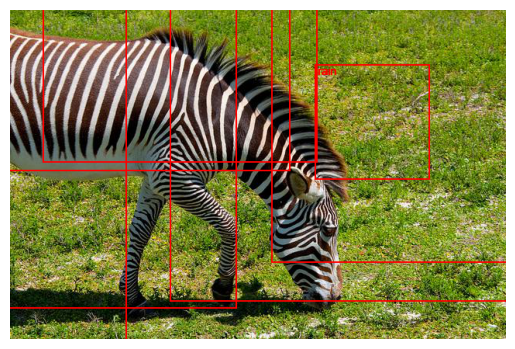

In [42]:
image_path = "data/coco128/images/train2017/000000000034.jpg"
inference(model, image_path, 0.7, 0.5)